In [57]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp # https://pypi.org/project/scikit-posthocs/
import stac
import matplotlib.pyplot as plt

# Read in our data for comparing

In [58]:
# Assumes a formattting where rows are datasets, and the methods are columns
df = pd.read_csv("data/scalograms.csv",delimiter="\t", index_col=0)
data = np.asarray(df)

print("Read data")

# To be safe, ensure this matches what was expected
num_datasets, num_methods = data.shape
print("Methods:", num_methods, "Datasets:", num_datasets)

Read data
Methods: 4 Datasets: 11


## Friedman testing 
Non parametric test to check if there is a difference in means between the groups (classifiers)

In [59]:
alpha = 0.05 # Set this to the desired alpha/signifance level

stat, p = stats.friedmanchisquare(*data)

reject = p <= alpha
print("Should we reject H0 (i.e. is there a difference in the means) at the", (1-alpha)*100, "% confidence level?", reject)
print(stat)
print(p)

Should we reject H0 (i.e. is there a difference in the means) at the 95.0 % confidence level? True
29.293849658314343
0.00111657781455193


### Post Hoc Analysis
See [Statistical Comparisons of Classifiers over Multiple Data Sets](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.141.3142&rep=rep1&type=pdf) for more detail

In [60]:
# At this point, we should only continue if H0 was rejected
if not reject:
    raise Exception("Exiting early. The rankings are only relevant if there was a difference in the means i.e. if we rejected h0 above")

In [61]:
# Helper functions for performing the statistical tests
def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
    pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}

    sp.sign_plot(scores, **heatmap_args)

#### Nemenyi Test
Note: This is relevant when you would like to compare various methods.
For example if you propose several methods and want to compare them all against each
other, or to do an exhaustive comparison against several method. Often this is not
what we want, as we propose only one method (instead see Bonferoni below), and this would
be overconservativew. 

In [62]:
nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, df.columns)

C:\Users\Josem\AppData\Local\Temp\ipykernel_26384\3969716403.py:4: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='columns', inplace=True) # Label the cols
C:\Users\Josem\AppData\Local\Temp\ipykernel_26384\3969716403.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pairwise_scores.set_axis(labels, axis='rows', inplace=True) # Label the rows, note: same label as pairwise combinations


In [63]:
# Shows the p values for each pair
nemenyi_scores

,MlKNN,MlKNN-daug,CNN,CNN-daug
MlKNN,1.000000,0.775321,0.900000,0.015642
MlKNN-daug,0.775321,1.000000,0.636277,0.165055
CNN,0.900000,0.636277,1.000000,0.007017
CNN-daug,0.015642,0.165055,0.007017,1.000000


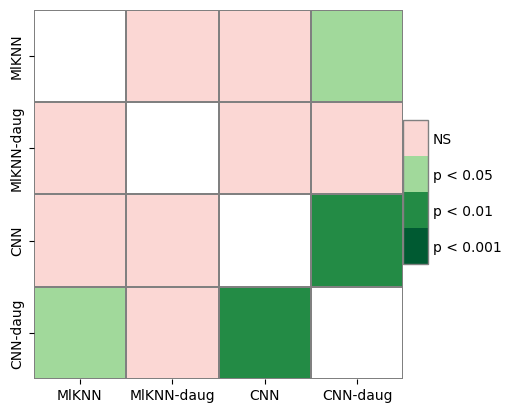

In [64]:
plot(nemenyi_scores)

#### Bonferoni-Holm Correction
In some cases, we do not care about all pairwise comparisons as we only propose a single method.
In this case we can prefer using the Bonferroni correction with a a control method, where the 
control is our proposed method.  This is confirmed in Statistical Comparisons of Classifiers over Multiple Data Sets with

"We thus should not make pairwise comparisons when we in fact only test whether a newly proposed method is better than the existing ones."

This is done with the "Holm" method here


**NOTE:** This relies on the method being called "*Proposed Method*" in the imported CSV file,
for lack of a generic way to set the control group.

In [65]:
# This library requires the data in different format to above, so was tranposed
statistic, p_value, ranking, rank_cmp  = stac.friedman_test(*np.transpose(data))
ranks = {key: rank_cmp[i] for i, key in enumerate(list(df.columns))} 

comparisons, z_values, p_values, adj_p_values = stac.holm_test(ranks, control="CNN-daug")
adj_p_values = np.asarray(adj_p_values)

In [66]:
# Rankings
for method, rank in sorted(ranks.items(), key=lambda x: x[1]):
    print(method +":", "%.2f" % rank)

CNN-daug: 2.48
MlKNN-daug: 4.54
MlKNN: 5.45
CNN: 5.70


In [67]:
holm_scores = pd.DataFrame({"p": adj_p_values, "adj_p_values":adj_p_values, "alpha":alpha,"z_values":z_values,"sig": adj_p_values < alpha}, index=comparisons)

In [68]:
holm_scores

,p,adj_p_values,alpha,z_values,sig
CNN-daug vs CNN,0.003841,0.003841,0.05,3.220319,True
CNN-daug vs MlKNN,0.005906,0.005906,0.05,2.972602,True
CNN-daug vs MlKNN-daug,0.038989,0.038989,0.05,2.064307,True
